# Sanity check for the contrastive learning loss

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from simple_model.model import SimCLR, train_simclr
from simple_model.dataloader import PairedContrastiveDataset, make_set

In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TENSORBOARD_BINARY'] = '/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/bin/tensorboard'

import pytorch_lightning as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import scanpy as sc
from pytorch_lightning.callbacks import TQDMProgressBar
%load_ext tensorboard

# Make toy data that is guaranteed to converge

In [4]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 190659 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

In [5]:
embeddings_a=adata_st.obsm["pca_embedding"]
labels_a=adata_st.obsm["brain_area_onehot"].toarray().nonzero()[-1]
embeddings_b=adata_histo.obsm["uni_pca_95"]
labels_b=adata_histo.obsm["brain_area_onehot"].toarray().nonzero()[-1]

## First check: Same modalities 

In [10]:
rng = np.random.default_rng()
ind = rng.choice(embeddings_a.shape[0], 5000, replace = False)
ind2 = rng.choice(embeddings_b.shape[0], 5000, replace = False)

In [30]:
toy_set = PairedContrastiveDataset(
    embeddings_a[ind], labels_a[ind], embeddings_a[ind], labels_a[ind], n_pos=5, n_neg=5, seed=42
)
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
model = train_simclr(
    toy_set, toy_set, "sanity_check/checkpoints", logger = logger, refresh_rate = 100, dropout = 0, 
    hidden_dims=[256, 128], latent_dim = 64, lr=5e-2, temperature=0.07, weight_decay=1e-4, histo_size = 50, 
    use_batchnorm = False, log_every = 100
)
model

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 54.2 K
1 | st_model    | SimpleModel | 54.2 K
--------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.434     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  50%|█████     | 10000/20000 [01:34<01:34, 106.18it/s, loss=-11.8, v_num=1]
idation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 10000/20000 [01:34<01:34, 105.36it/s, loss=-17.6, v_num=1]
idation: 0it [00:00, ?it/s]
Epoch 2:  46%|████▌     | 9100/20000 [01:29<01:47, 101.73it/s, loss=-17, v_num=1]   

SimCLR(
  (histo_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (st_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
)

The loss is fluctuating very much, but always stays negative, meanwhile the accuracy metrics all stay at one consistently across all steps, which indicates perfect performance, but also maybe the calculations are a bit off. Let's check by making another model that should NOT be able to learn anything.
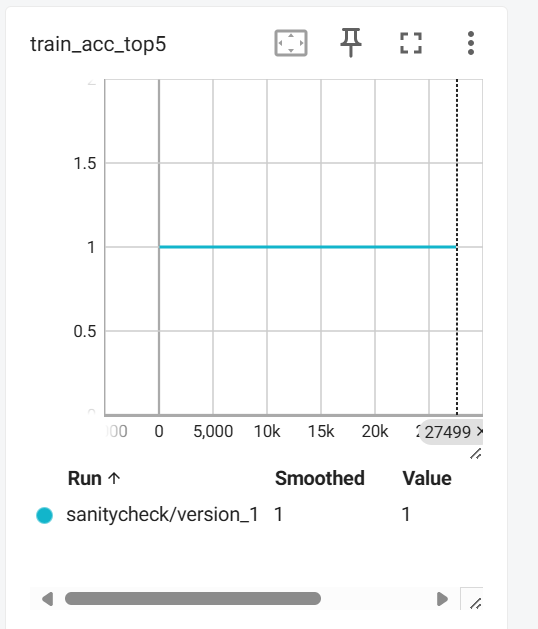
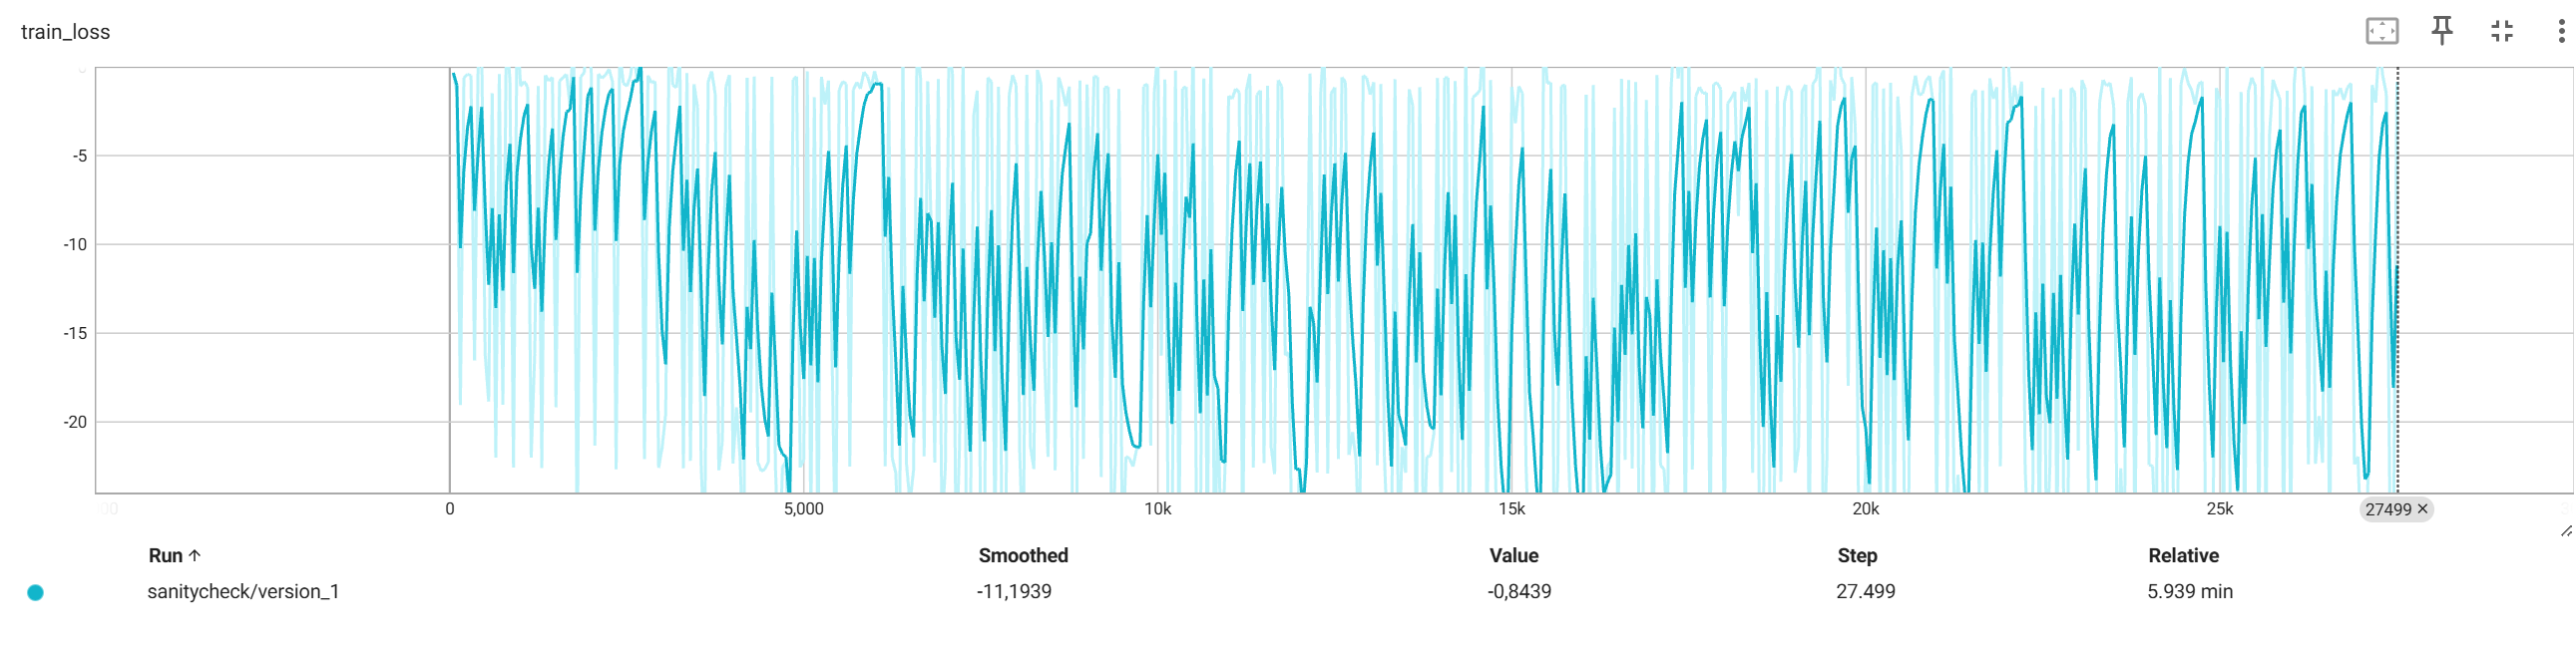

### Bad model

In [5]:
random_emb1 = np.random.rand(2000, 50)
random_emb2 = np.random.rand(2000, 368)
random_classes = np.round(np.random.rand(2000)).astype(int)

toy_set = PairedContrastiveDataset(
    random_emb1, random_classes, random_emb2, random_classes, n_pos=5, n_neg=10, seed=42
)
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
model = train_simclr(
    toy_set, toy_set, "sanity_check/checkpoints", logger = logger, refresh_rate = 100, dropout = 0, 
    hidden_dims=[256, 128], latent_dim = 64, lr=5e-2, temperature=0.07, weight_decay=1e-4,
    use_batchnorm = False, log_every = 100
)
model

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 135 K 
1 | st_model    | SimpleModel | 54.2 K
--------------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total params
0.759     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  50%|█████     | 4000/8000 [00:42<00:42, 93.11it/s, loss=0.799, v_num=3]
idation: 0it [00:00, ?it/s]
Epoch 1:  16%|█▋        | 1300/8000 [00:14<01:17, 86.86it/s, loss=0.799, v_num=3] 

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


SimCLR(
  (histo_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=368, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (st_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
)

=> This is also stable at 1, so the calculation must be off... Let's check

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
positives = random_emb1 = torch.tensor(np.random.rand(10, 50)).to(device)
negatives = random_emb1 = torch.tensor(np.random.rand(20, 50)).to(device)
features = ((positives, positives), (positives, negatives))
similarities = []
nce_parts = []
for i in range(2):
    # Repeat for positives and negatives
    feat1, feat2 = features[i]
    
    cos_sim = F.cosine_similarity(feat1[:,None,:], feat2[None,:,:], dim=-1)
    if i == 0:
        # Remove the diagonal from positive to positive comparison
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    cos_sim = cos_sim / 1e-6
    
    nce_parts.append(torch.logsumexp(cos_sim, dim=-1))
    similarities.append(cos_sim)
similarities[0].shape

torch.Size([10, 10])

In [8]:
similarities[1].shape

torch.Size([10, 20])

[]

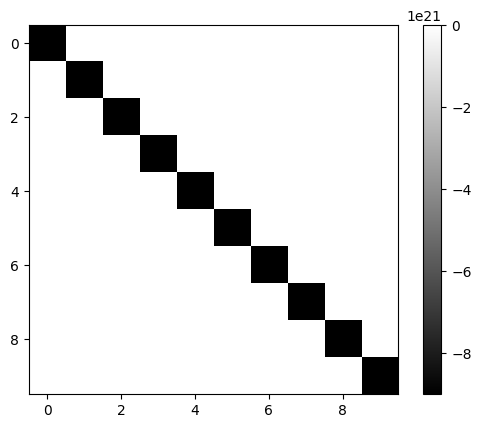

In [9]:
plt.imshow(similarities[0].detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.plot()

[]

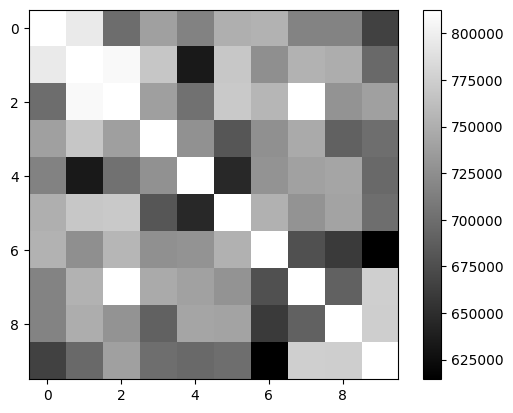

In [10]:
sim1_no_diagonal = similarities[0].detach().cpu().numpy()
np.fill_diagonal(sim1_no_diagonal, np.nan)
sim1_no_diagonal[~np.isnan(sim1_no_diagonal)].reshape(sim1_no_diagonal.shape[0], sim1_no_diagonal.shape[1] - 1)

plt.imshow(sim1_no_diagonal, cmap='gray')
plt.colorbar()
plt.plot()

[]

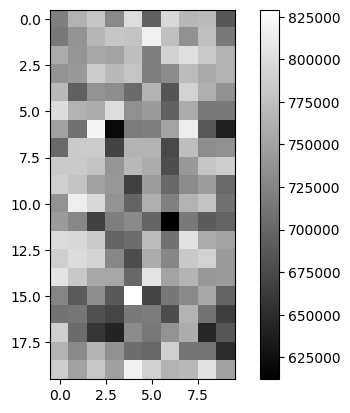

In [11]:
plt.imshow(similarities[1].detach().cpu().numpy().T, cmap='gray')
plt.colorbar()
plt.plot()

==> In the similarities, the -9e15 dominates the whole sum. We need to get rid of it when calculating the accuracy rank

In [17]:
mode = "test"
n_pos = positives.shape[0]
n_neg = negatives.shape[0]
similarities[0].masked_fill_(self_mask, 0)
comb_sim = torch.cat([
    similarities[0].sum(dim = 0) / (n_pos - 1),  # Mean cosine distance of positive samples
    similarities[1].mean(dim = 0)  # Again for negative samples
], dim = -1)
sim_argsort = comb_sim.argsort(dim=-1, descending=False) 
classes = torch.cat([torch.ones(n_pos), torch.zeros(n_neg)], dim = -1).to(sim_argsort.device)

assert sim_argsort.max() < len(classes)
top_classes = classes[sim_argsort] 
print(mode+'_acc_top1', top_classes[0].float())
print(mode+'_acc_top5', top_classes[:5].float().mean())
print(mode+'_acc_mean_pos', top_classes[:n_pos].float().mean())

test_acc_top1 tensor(0., device='cuda:0')
test_acc_top5 tensor(0.2000, device='cuda:0')
test_acc_mean_pos tensor(0.5000, device='cuda:0')


In [18]:
comb_sim

tensor([739494.7959, 755897.8985, 741043.9151, 759850.3096, 730996.4931,
        735757.2579, 762617.9064, 771299.8843, 761885.0028, 740436.2584,
        737719.5021, 771680.8566, 765370.2496, 752817.4925, 705845.9954,
        754442.6763, 717878.0387, 782811.2754, 760805.6968, 776212.1485,
        766938.0639, 748810.0607, 711866.4681, 753640.9594, 728457.2003,
        757281.5236, 750460.1881, 750190.6521, 745993.4482, 783373.5292],
       device='cuda:0', dtype=torch.float64)

==> The trick was to refill the diagonal with 0 to make distances comparable. But that might alter the backpropagation, so let's try to use it with torch.no_grad()

#### Rerun the bad model

In [21]:
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
model = train_simclr(
    toy_set, toy_set, "sanity_check/checkpoints", logger = logger, refresh_rate = 100, dropout = 0, 
    hidden_dims=[256, 128], latent_dim = 64, lr=5e-2, temperature=0.07, weight_decay=1e-4,
    use_batchnorm = False, log_every = 100
)
model

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 135 K 
1 | st_model    | SimpleModel | 54.2 K
--------------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total params
0.759     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  50%|█████     | 4000/8000 [00:40<00:40, 98.06it/s, loss=0.799, v_num=4]
idation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 4000/8000 [00:40<00:40, 99.39it/s, loss=0.799, v_num=4] 
idation: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 4000/8000 [00:41<00:41, 96.45it/s, loss=0.799, v_num=4] 
idation: 0it [00:00, ?it/s]
Epoch 3:   2%|▎         | 200/8000 [00:06<03:58, 32.70it/s, loss=0.799, v_num=4]

SimCLR(
  (histo_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=368, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (st_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
)

Now the accuracy fluctuates between 0.4 and 0.7
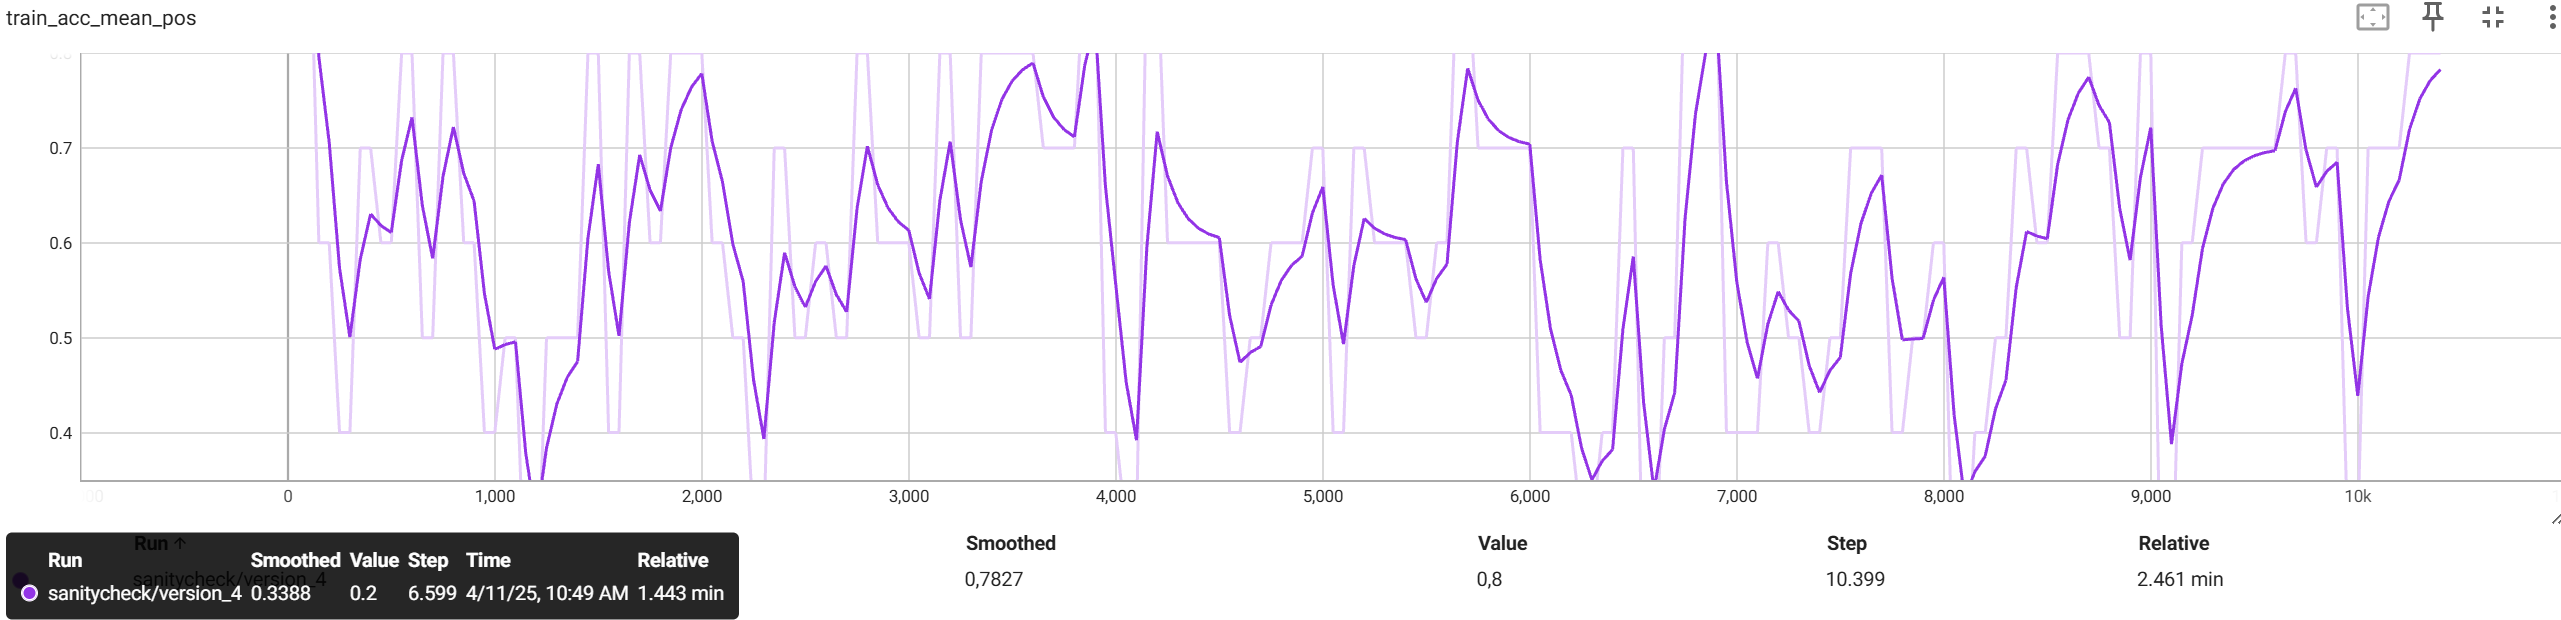

# Try a good (easy) dataset

Only use two brain areas that are very different CB and HIP

In [31]:
st_CBorHIP = adata_st.obs.brain_area.isin(["CB", "HIP"])
histo_CBorHIP = adata_histo.obs.brain_area.isin(["CB", "HIP"])
embeddings_a=adata_st.obsm["pca_embedding"][st_CBorHIP]
labels_a=adata_st.obsm["brain_area_onehot"].toarray().nonzero()[-1][st_CBorHIP]
embeddings_b=adata_histo.obsm["uni_pca_95"][histo_CBorHIP]
labels_b=adata_histo.obsm["brain_area_onehot"].toarray().nonzero()[-1][histo_CBorHIP]
embeddings_a.shape, embeddings_b.shape

((4448, 50), (26774, 368))

In [31]:
easy_set = PairedContrastiveDataset(
    embeddings_a, labels_a, embeddings_b, labels_b, n_pos=12, n_neg=64, seed=42
)
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
model = train_simclr(
    easy_set, easy_set, "sanity_check/checkpoints", logger = logger, refresh_rate = 50, dropout = 0, 
    hidden_dims=[256, 128], latent_dim = 64, lr=5e-4, temperature=0.07, weight_decay=1e-4,
    use_batchnorm = False, log_every = 100
)
model

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 135 K 
1 | st_model    | SimpleModel | 54.2 K
--------------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total params
0.759     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  50%|████▉     | 31200/62444 [05:11<05:11, 100.19it/s, loss=-25.7, v_num=8]
idation: 0it [00:00, ?it/s]
Epoch 1:  50%|████▉     | 31200/62444 [06:09<06:10, 84.40it/s, loss=-25.7, v_num=8] 
idation: 0it [00:00, ?it/s]
Epoch 2:  50%|████▉     | 31200/62444 [05:07<05:08, 101.40it/s, loss=-26.9, v_num=8]
idation: 0it [00:00, ?it/s]
Epoch 3:   4%|▍         | 2350/62444 [00:27<11:46, 85.05it/s, loss=-26.9, v_num=8]  

SimCLR(
  (histo_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=368, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (st_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
)

The loss decreases and then only fluctuates, but at a very low level. Weirdly, the accuracy goes to zero instead of 1, and stays there steadily apart from small spikes
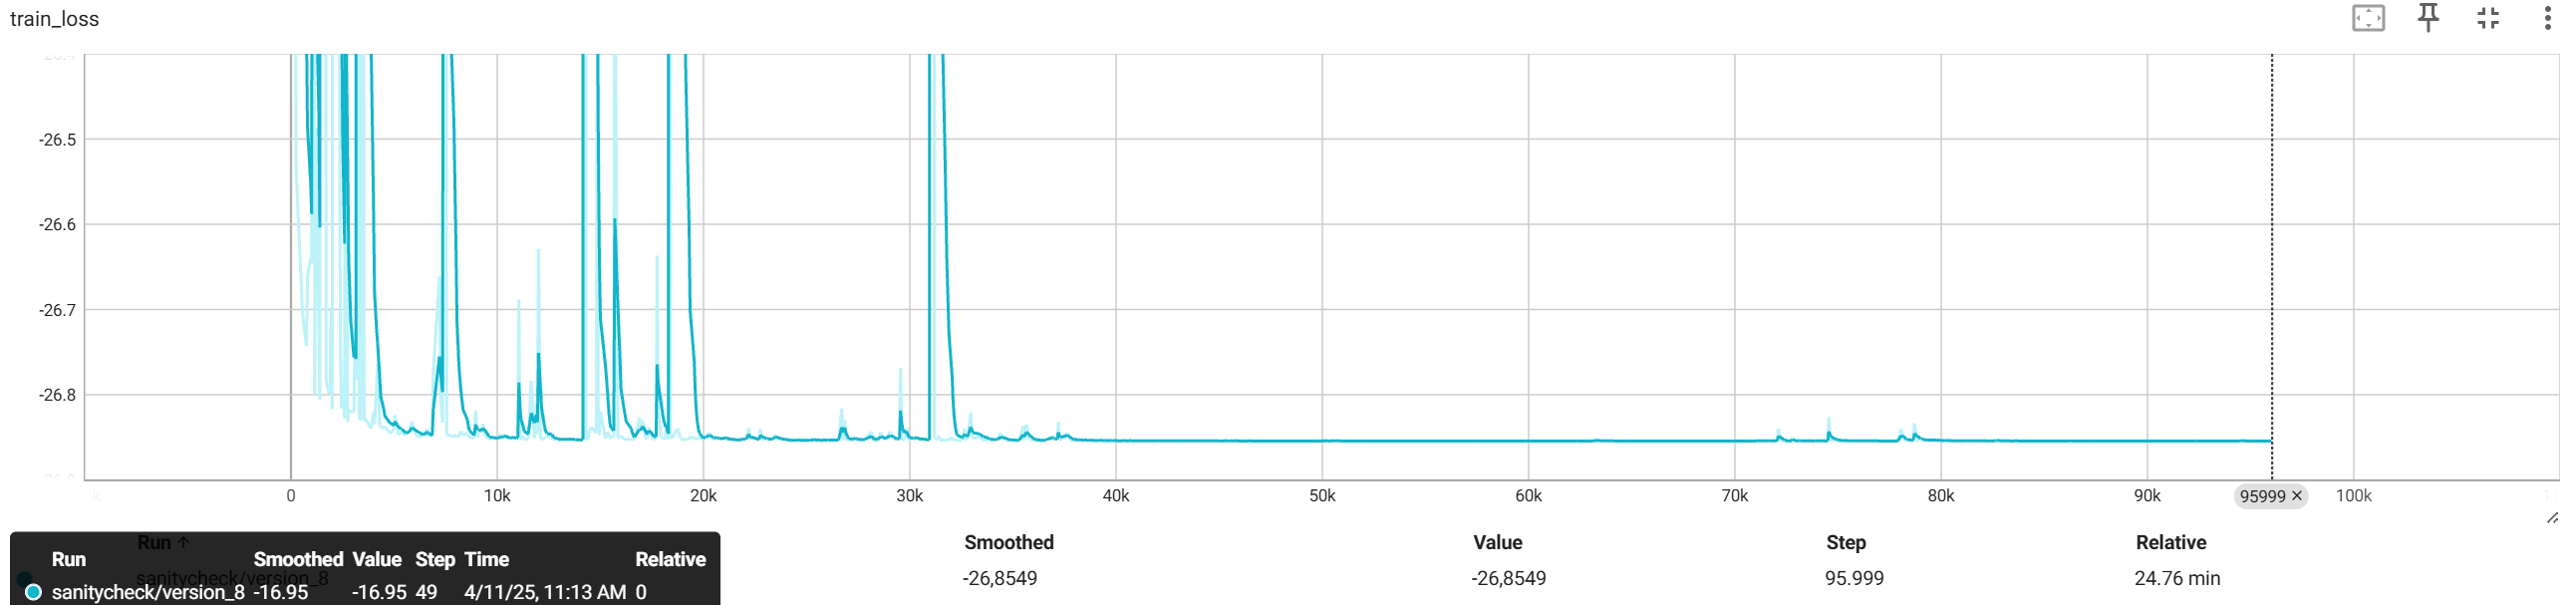
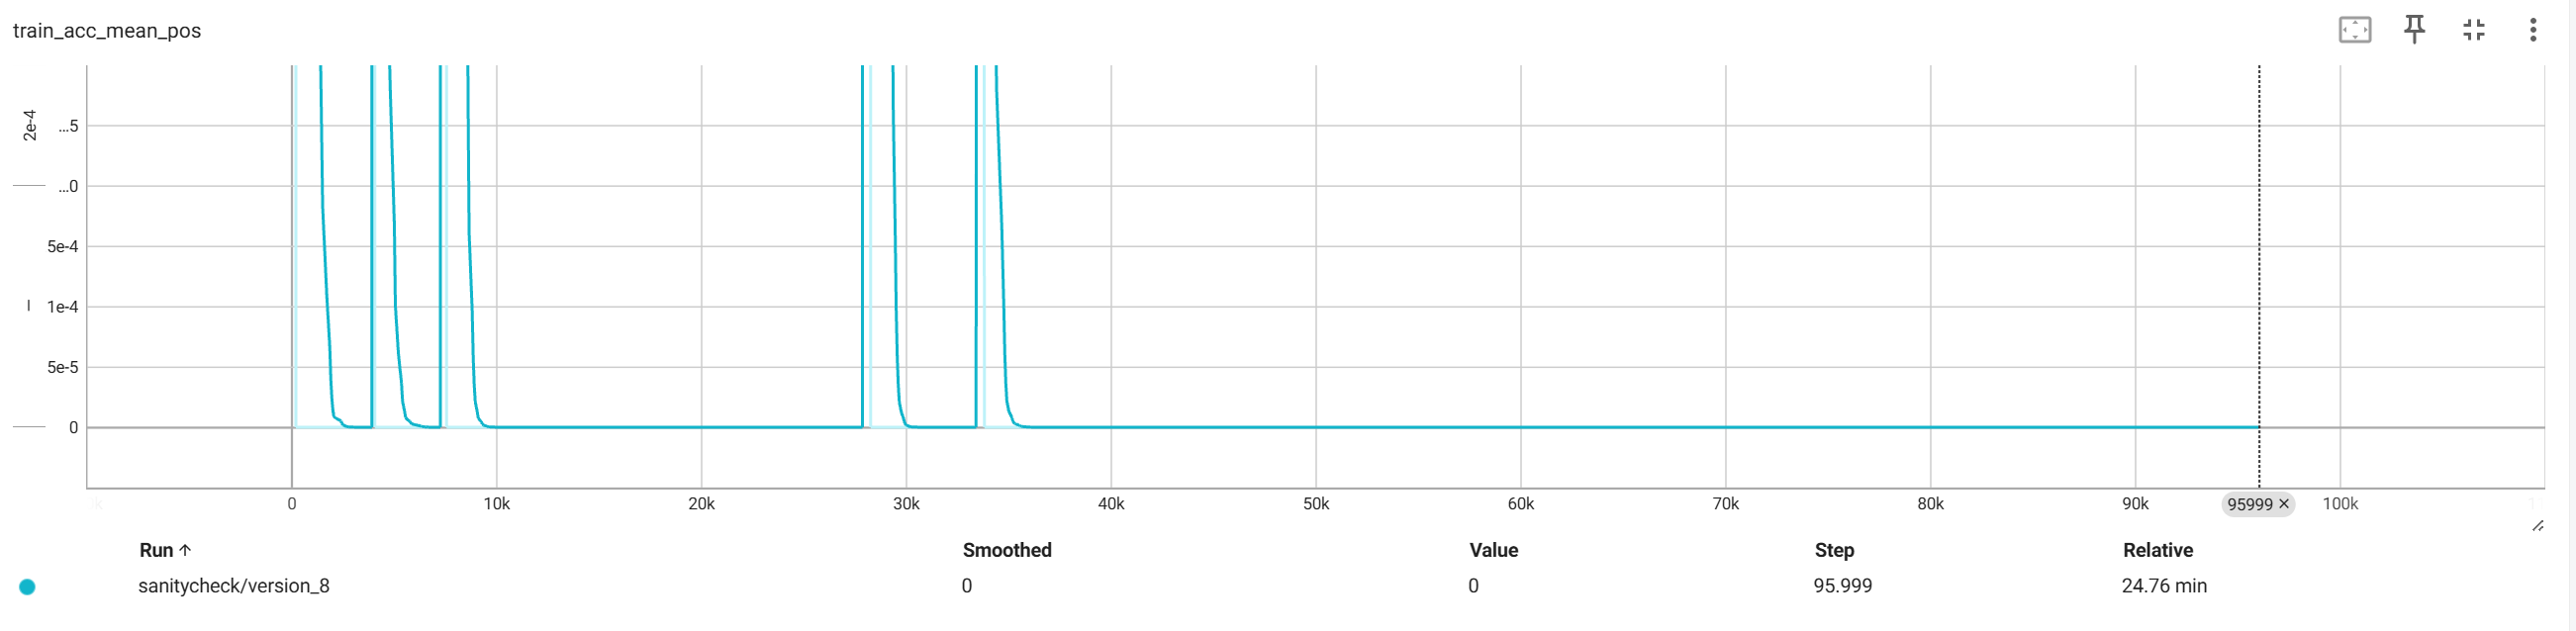

In [37]:
comb_sim = torch.cat([torch.zeros(n_pos), torch.ones(n_neg)]).to("cuda:0")
sim_argsort = comb_sim.argsort(dim=-1, descending=False) 
classes = torch.cat([torch.ones(n_pos), torch.zeros(n_neg)], dim = -1).to(sim_argsort.device)

assert sim_argsort.max() < len(classes)
top_classes = classes[sim_argsort] 

print(mode+'_acc_top1', top_classes[0].float())
print(mode+'_acc_top5', top_classes[:5].float().mean())
print(mode+'_acc_mean_pos', top_classes[:n_pos].float().mean())
top_classes

test_acc_top1 tensor(1., device='cuda:0')
test_acc_top5 tensor(1., device='cuda:0')
test_acc_mean_pos tensor(1., device='cuda:0')


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

==> The calculations seem correct, so there must be another error

In [39]:
model.histo_model

SimpleModel(
  (model): Sequential(
    (0): Linear(in_features=368, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
)

### Even easier model

Since cosine similarity is a similarity, we want o maximize it between positive samples and minimize it between negative samples, DUH :(. So just inverse the sorting order and it should be fine

In [12]:
a = np.vstack((np.zeros((50, 50)), np.ones((50, 50))))
b = np.vstack((np.zeros((50, 368)), np.ones((50, 368))))
labels_a = np.vstack((np.zeros((50,1)), np.ones((50,1)))).flatten()
labels_b = np.vstack((np.zeros((50,1)), np.ones((50,1)))).flatten()

super_easy_set = PairedContrastiveDataset(
    a, labels_a, b, labels_b, n_pos=2, n_neg=4, seed=42
)
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
super_easy_model = train_simclr(
    super_easy_set, super_easy_set, "sanity_check/checkpoints", logger = logger, refresh_rate = 50, dropout = 0, 
    hidden_dims=[256, 128], latent_dim = 64, lr=5e-4, temperature=0.07, weight_decay=1e-4,
    use_batchnorm = False, log_every = 100
)

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 135 K 
1 | st_model    | SimpleModel | 54.2 K
--------------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total params
0.759     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  50%|█████     | 200/400 [00:05<00:05, 39.51it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 200/400 [00:05<00:05, 36.40it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 200/400 [00:05<00:05, 35.55it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 200/400 [00:05<00:05, 35.99it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 200/400 [00:05<00:05, 35.33it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 200/400 [00:05<00:05, 33.56it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 200/400 [00:06<00:06, 32.77it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 200/400 [00:05<00:05, 33.64it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 200/400 [00:05<00:05, 35.04it/s, loss=-27.6, v_num=11]
idation: 0it [00:00, ?it/s]
Epoch 9:  50%|█████

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


==> Now, the accuracy reaches 0

### Repeat easy model with actual data

In [14]:
easy_set = PairedContrastiveDataset(
    embeddings_a, labels_a, embeddings_b, labels_b, n_pos=12, n_neg=64, seed=42
)
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
model = train_simclr(
    easy_set, easy_set, "sanity_check/checkpoints", logger = logger, refresh_rate = 50, dropout = 0, 
    hidden_dims=[256, 128], latent_dim = 64, lr=5e-4, temperature=0.07, weight_decay=1e-4,
    use_batchnorm = False, log_every = 100
)
model

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 135 K 
1 | st_model    | SimpleModel | 54.2 K
--------------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total params
0.759     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  50%|████▉     | 31200/62444 [05:03<05:03, 102.95it/s, loss=-25.7, v_num=12]
idation: 0it [00:00, ?it/s]
Epoch 1:  10%|▉         | 5950/62444 [01:01<09:40, 97.26it/s, loss=-25.7, v_num=12]  

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


SimCLR(
  (histo_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=368, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (st_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
)

This learns very effortlessly
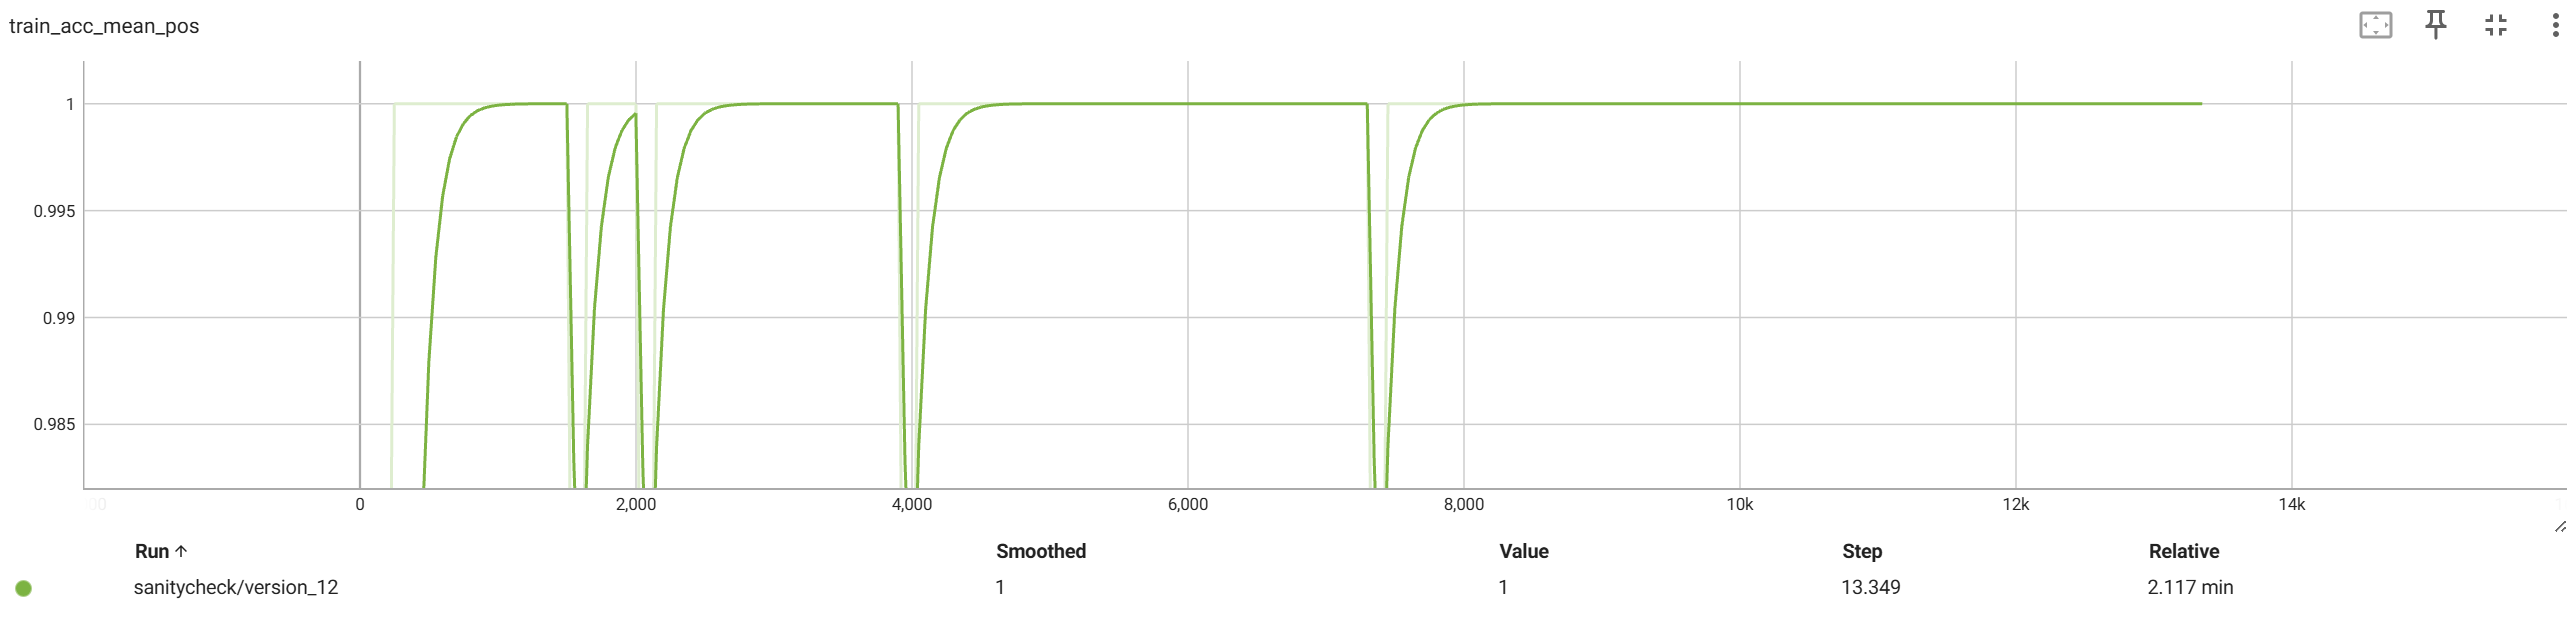

## Try the shuffling of dataset

In [28]:
def make_set(ad1, ad2, n_pos, n_neg, random_seed):
    ind = rng.choice(ad1.shape[0], 5000, replace = False)
    ind2 = rng.choice(ad2.shape[0], 5000, replace = False)
    embeddings_a=ad1.obsm["pca_embedding"][ind]
    labels_a=ad1.obsm["brain_area_onehot"].toarray().nonzero()[-1][ind]
    embeddings_b=ad2.obsm["uni_pca_95"][ind2]
    labels_b=ad2.obsm["brain_area_onehot"].toarray().nonzero()[-1][ind2]
    
    return PairedContrastiveDataset(
        embeddings_a=embeddings_a, 
        labels_a=labels_a, 
        embeddings_b=embeddings_b, 
        labels_b=labels_b, 
        n_pos=n_pos,
        n_neg=n_neg,
        seed=random_seed,
        shuffle = False
    )

train_dataset = make_set(
    adata_st[adata_st.obs.train_set],
    adata_histo[adata_histo.obs.train_set],
    n_pos=3,
    n_neg=5,
    random_seed=42
)
val_dataset = make_set(
    adata_st[adata_st.obs.val_set],
    adata_histo[adata_histo.obs.val_set],
    n_pos=3,
    n_neg=5,
    random_seed=42
)

In [30]:
for i in range(len(train_dataset)):
    train_dataset[i]

## Now it works, let's look at the performance to see if there were misindexings

In [36]:
st_CBorHIP = adata_st.obs.brain_area.isin(["CB", "HIP"])
histo_CBorHIP = adata_histo.obs.brain_area.isin(["CB", "HIP"])
embeddings_a=adata_st.obsm["pca_embedding"][st_CBorHIP]
labels_a=adata_st.obsm["brain_area_onehot"].toarray().nonzero()[-1][st_CBorHIP]
embeddings_b=adata_histo.obsm["uni_pca_95"][histo_CBorHIP]
labels_b=adata_histo.obsm["brain_area_onehot"].toarray().nonzero()[-1][histo_CBorHIP]

ind = np.zeros(embeddings_a.shape[0]).astype(bool)
ind[rng.choice(embeddings_a.shape[0], 300, replace = False)] = True
ind2 = np.zeros(embeddings_b.shape[0]).astype(bool)
ind2[rng.choice(embeddings_b.shape[0], 600, replace = False)] = True

easy_set_val = PairedContrastiveDataset(
    embeddings_a[ind], labels_a[ind], embeddings_b[ind2], labels_b[ind2], n_pos=12, n_neg=64, seed=42
)
easy_set_train = PairedContrastiveDataset(
    embeddings_a[~ind], labels_a[~ind], embeddings_b[~ind2], labels_b[~ind2], n_pos=12, n_neg=64, seed=42
)
logger = pl.loggers.TensorBoardLogger("sanity_check/logs/", name="sanitycheck")
model = train_simclr(
    easy_set_train, easy_set_val, "sanity_check/checkpoints", logger = logger, refresh_rate = 50, dropout = 0.2, 
    hidden_dims=[256, 128], latent_dim = 128, lr=5e-4, temperature=0.07, weight_decay=1e-4,
    use_batchnorm = False, log_every = 100, shuffle_every = 5
)
model

Global seed set to 42
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /p/project1/hai_fzj_bda/koenig8/jupyter/kernels/cont ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


NUM_WORKERS: 80


/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:101: UserWarning: attribute 'train_set' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 143 K 
1 | st_model    | SimpleModel | 62.5 K
--------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.825     Total estimated model params size (MB)


Epoch 0:  97%|█████████▋| 30300/31222 [27:44<00:50, 18.20it/s, loss=-25.7, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 30300/31222 [28:24<00:51, 17.78it/s, loss=-25.7, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 30300/31222 [27:49<00:50, 18.15it/s, loss=-26.9, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 30300/31222 [27:52<00:50, 18.12it/s, loss=-26.9, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 30300/31222 [28:03<00:51, 18.00it/s, loss=-26.9, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 30300/31222 [28:49<00:52, 17.52it/s, loss=-26.9, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 6:  97%|█████████▋| 30300/31222 [29:00<00:52, 17.41it/s, loss=-26.9, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 7:  97%|█████████▋| 30300/31222 [28:34<00:52, 17.67it/s, loss=-26.9, v_num=23]
idation: 0it [00:00, ?it/s]
Epoch 8:  55%|█████▍    | 17100/31222 [16:09<13:20, 17.64it/s, loss=-26.9, v_num=23]

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


SimCLR(
  (histo_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=368, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (st_model): SimpleModel(
    (model): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)